## This notebok is used to visualize the results of the final model's predictions for the entire dataset

# Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from cycler import cycler

# Get dataframe with predicted and actual runtime

In [2]:
pred_vs_act_df = pd.read_parquet('../data/pred_vs_act.parquet')
pred_vs_act_df

,runtime_pred,runtime_act
0,19253.605469,124876.0
1,833.113647,400.0
2,258.808960,410.0
3,739.797302,400.0
4,258.808960,401.0
...,...,...
8038893,1637.175171,134.0
8038894,1637.175171,148.0
8038895,13667.119141,12865.0
8038896,13667.119141,1680.0


## Compute absolute error

In [3]:
pred_vs_act_df['error'] = pred_vs_act_df.runtime_pred - pred_vs_act_df.runtime_act
pred_vs_act_df['abs_error'] = abs(pred_vs_act_df['error'])

In [4]:
def plot_err_dist(df, l_bound, r_bound, color, line_color, axes=None):
    error_sample = df[df.runtime_act.between(l_bound,r_bound,inclusive='right')].abs_error/60
    if axes:
        axes.hist(error_sample, bins=np.logspace(-3,4,50), color=color)
    else:
        plt.hist(error_sample, bins=np.logspace(-3,4,50), color=color, alpha=0.8)
    med_err = error_sample.median()
    med_err_fin = med_err
    med_err_label = 'minutes'
    if med_err > 60:
        med_err_fin = med_err/60
        med_err_label = 'hours'
    bounds = '('
    for bound in (l_bound, r_bound):
        if bound < 60*60:
            new_bound = str(bound//60) + 'm'
        elif bound < 60*60*24:
            new_bound = str(bound//(60*60)) + 'h'
        else:
            new_bound = str(bound//(24*60*60)) + 'd'
        bounds += (new_bound + ', ')
    bounds = bounds[:-2] + ']'
    if axes:
        axes.vlines(med_err, 0, 250000, linestyle='--', color=line_color, label=f'{med_err_fin:.1f} {med_err_label}')
    else:
        plt.vlines(med_err, 0, 250000, linestyle='--', color=line_color, label='{:>19}'.format(f'{bounds} Med Err: ') + f'{med_err_fin:.1f} {med_err_label}')
    
    return bounds

# Visualize absolute error for jobs grouped by actual runtime

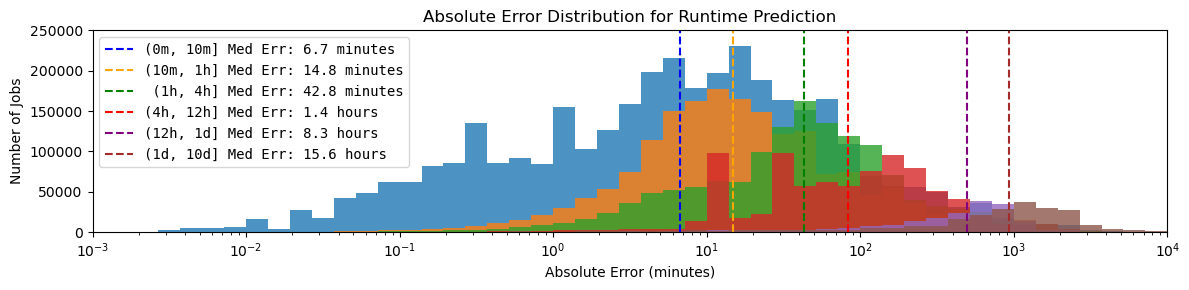

In [5]:
plt.figure(figsize=(12,3))
bounds = [0,60*10,60*60,60*60*4,60*60*12,60*60*24,60*60*24*10]
colors = [item['color'] for item in mpl.rcParams['axes.prop_cycle']]
line_colors = ['blue','orange','green','red','purple','brown']

for i,bound in enumerate(bounds):
    if i == len(bounds) - 1:
        break
    l_bound = bound
    r_bound = bounds[i + 1]
    color = colors[i]
    line_color = line_colors[i]
    instance_bounds = plot_err_dist(pred_vs_act_df, l_bound, r_bound, color, line_color)
    
plt.xscale('log')
plt.xlim(.001,10000)
plt.ylim([0, 250000])
plt.legend(loc='upper left', prop={'family': 'DejaVu Sans Mono'})
plt.title('Absolute Error Distribution for Runtime Prediction')
plt.xlabel('Absolute Error (minutes)')
plt.ylabel('Number of Jobs')
plt.tight_layout()
plt.show()

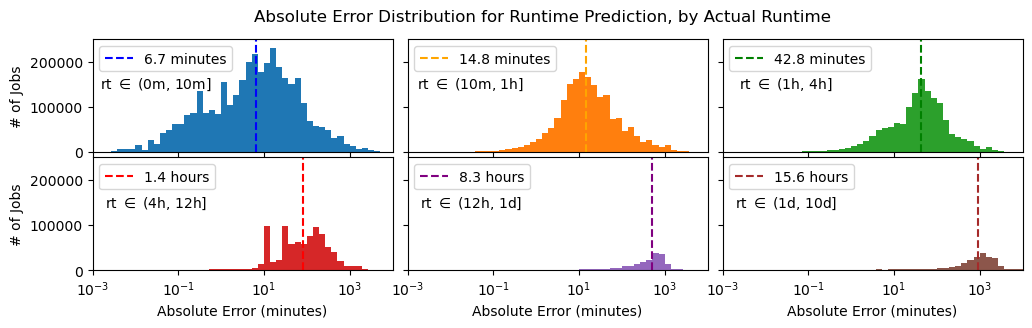

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,3))
fig.subplots_adjust(wspace=0.05, hspace=0.05)

colors = [item['color'] for item in mpl.rcParams['axes.prop_cycle']]
line_colors = ['blue','orange','green','red','purple','brown']

formatted_bounds = list()

bounds = [0,60*10,60*60,60*60*4,60*60*12,60*60*24,60*60*24*10]
colors = [item['color'] for item in mpl.rcParams['axes.prop_cycle']]

for i, bound in enumerate(bounds):
    if i == len(bounds) - 1:
        break
    l_bound = bound
    r_bound = bounds[i + 1]
    color = colors[i]
    line_color = line_colors[i]
    instance_bounds = plot_err_dist(pred_vs_act_df, l_bound, r_bound, color, line_color, axes[i//3,i%3])
    formatted_bounds.append(instance_bounds)

windows = list()

for f_b in formatted_bounds:
    windows.append(f'rt $\in$ {f_b}')

for i, ax in enumerate(axes.flatten()):
    ax.set_xscale('log')
    ax.set_xlim(.001,10000)
    ax.set_ylim([0, 250000])
    ax.legend(loc='upper left')
    if i not in [0,3]:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('# of Jobs')
    if i < 3:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Absolute Error (minutes)')
    ax.text(.03,150000,windows[i],ha='center',va='center')
plt.suptitle('Absolute Error Distribution for Runtime Prediction, by Actual Runtime')
plt.show()

# Analyze and visualize the results for the entire dataset

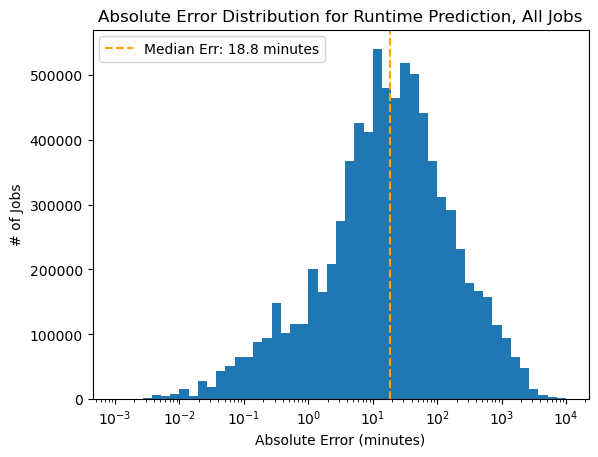

In [7]:
plt.hist(pred_vs_act_df['abs_error']/60, bins = np.logspace(-3,4))
med_err = pred_vs_act_df['abs_error'].median()/60
plt.vlines(med_err,0,750000, color='orange',linestyle='--',label=f'Median Err: {med_err:.1f} minutes')
plt.ylim([0,570000])
plt.xscale('log')
plt.legend()
plt.title('Absolute Error Distribution for Runtime Prediction, All Jobs')
plt.ylabel('# of Jobs')
plt.xlabel('Absolute Error (minutes)')
plt.show()

In [8]:
rmse = mean_squared_error(pred_vs_act_df.runtime_act, pred_vs_act_df.runtime_pred, squared=False)
r2 = r2_score(pred_vs_act_df.runtime_act, pred_vs_act_df.runtime_pred)
print(f'R2 Score: {r2}, RMSE: {rmse/3600}')

R2 Score: 0.4172827553188231, RMSE: 7.797524655996291


In [9]:
x = pred_vs_act_df.runtime_act / 3600
y = pred_vs_act_df.runtime_pred / 3600

bin_size = 1

x_binned = np.floor(x / bin_size) * bin_size

binned_data = {}
for i in range(len(x)):
    if x_binned[i] not in binned_data:
        binned_data[x_binned[i]]= [y[i]]
    else:
        binned_data[x_binned[i]].append(y[i])
        
x_vals = []
y_med = []
y_mean = []
for k, v in binned_data.items():
    x_vals.append(k)
    y_med.append(np.median(v))
    y_mean.append(np.mean(v))

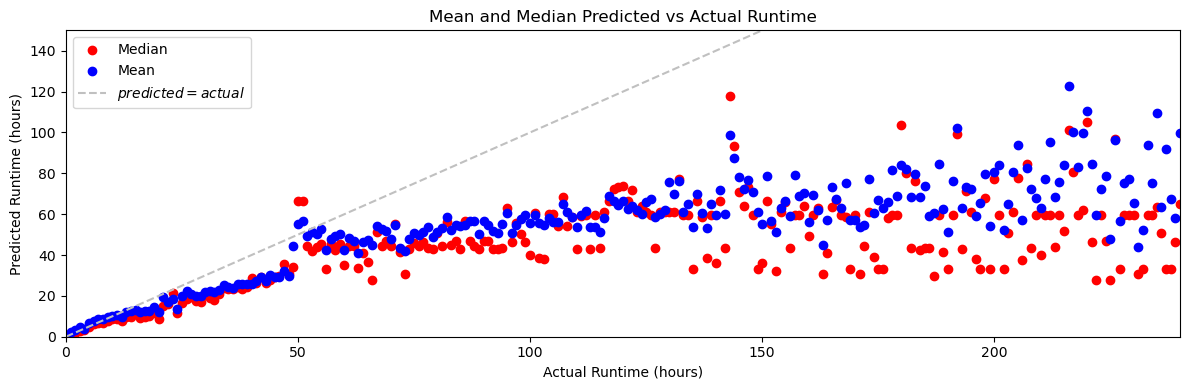

In [10]:
#plt.scatter(x, y, alpha=0.1, c='yellow')
#plt.figure(figsize=(8,5))
plt.figure(figsize=(12,4))
plt.scatter(x_vals, y_med, c='r', label='Median')
plt.scatter(x_vals, y_mean, c='b', label='Mean')
plt.xlim([0,240])
plt.ylim([0,150])
plt.plot(np.linspace(0,240),np.linspace(0,240),c='silver',linestyle='--',label='$predicted=actual$')
plt.xlabel('Actual Runtime (hours)')
plt.ylabel('Predicted Runtime (hours)')
plt.title('Mean and Median Predicted vs Actual Runtime')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
x = pred_vs_act_df.runtime_act / 3600
y = pred_vs_act_df.runtime_pred / 3600

bin_size = 1/60

x_binned = np.floor(x / bin_size) * bin_size

binned_data = {}
for i in range(len(x)):
    if x_binned[i] not in binned_data:
        binned_data[x_binned[i]]= [y[i]]
    else:
        binned_data[x_binned[i]].append(y[i])
        
x_vals = []
y_med = []
y_mean = []
for k, v in binned_data.items():
    x_vals.append(k)
    y_med.append(np.median(v))
    y_mean.append(np.mean(v))

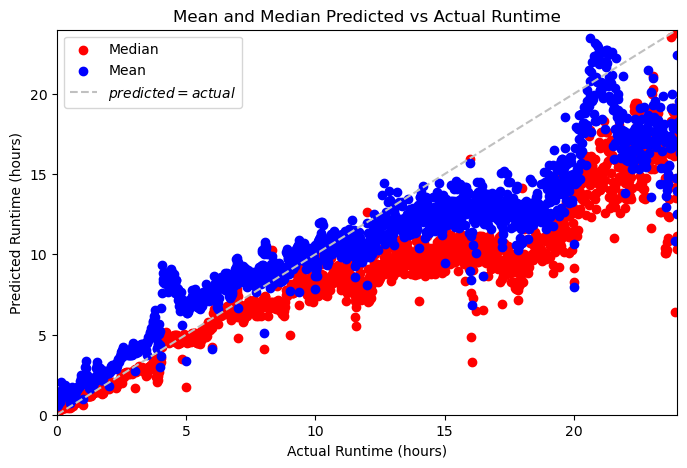

In [12]:
plt.figure(figsize=(8,5))
plt.scatter(x_vals, y_med, c='r', label='Median')
plt.scatter(x_vals, y_mean, c='b', label='Mean')
plt.xlim([0,24])
plt.ylim([0,24])
plt.plot(np.linspace(0,240),np.linspace(0,240),c='silver',linestyle='--',label='$predicted=actual$')
plt.xlabel('Actual Runtime (hours)')
plt.ylabel('Predicted Runtime (hours)')
plt.title('Mean and Median Predicted vs Actual Runtime')
plt.legend()
plt.show()